In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
import os 
import joblib

from flask import Flask, request, jsonify
import joblib
from flask_cors import CORS
from sklearn.preprocessing import LabelEncoder
import urllib.parse
import math
from collections import Counter  
import re
import numpy as np
import pandas as pd

df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)
df2 = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\source.csv', low_memory=False)

df['url'] =  df2['url']

print(df.head())

   Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
0            0                   1                 4                0.0   
1            0                   1                 6                0.0   
2            0                   1                 6                0.0   
3           49                   4                 3                4.5   
4          194                   3                 3                7.0   

   longdomaintokenlen  avgpathtokenlen  tld  charcompvowels  charcompace  \
0                   0         3.250000  NaN               4            0   
1                   0         5.000000  NaN               9            0   
2                   0         4.333333  NaN               6            0   
3                   7         2.666667   be              22            0   
4                   9         2.666667  net              33            0   

   ldl_url  ...  SymbolCount_FileName  SymbolCount_Extension  \
0       16  ...             

In [10]:
print(df.isnull().sum())  # Check for missing values
df.fillna(0, inplace=True)

Querylength           0
domain_token_count    0
path_token_count      0
avgdomaintokenlen     0
longdomaintokenlen    0
                     ..
url_type              0
url                   0
is_shortener          0
url_type_encoded      0
binary_label          0
Length: 74, dtype: int64


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
import os 
import joblib
# Import additional libraries
import tldextract

# Define known URL shorteners
url_shorteners = [
    "bit.ly", "tinyurl.com", "goo.gl", "ow.ly", "t.co", "is.gd", 
    "buff.ly", "rebrand.ly", "shorte.st", "lnkd.in", "v.gd"
]

# Add a feature to check if the domain is a known shortener
def is_shortener(url):
    domain_info = tldextract.extract(url)
    domain = f"{domain_info.domain}.{domain_info.suffix}"
    return 1 if domain in url_shorteners else 0

df['is_shortener'] = df['url'].apply(is_shortener)

# Adjust features and targets
features = ['Querylength', 'domain_token_count', 'path_token_count', 
            'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen',
            'charcompvowels', 'ldl_url', 'ldl_domain', 'ldl_path', 
            'subDirLen', 'NumberofDotsinURL', 'CharacterContinuityRate', 
            'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 
            'URL_DigitCount', 'SymbolCount_URL', 'spcharUrl', 'is_shortener']

# Encode 'tld' and 'url_type'
df['tld'] = df['tld'].astype(str)
df['url_type'] = df['url_type'].astype(str)

label_encoder_url_type = LabelEncoder()
df['url_type_encoded'] = label_encoder_url_type.fit_transform(df['url_type'])

# Binary classification target (benign vs malicious)
df['binary_label'] = df['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Feature selection (add encoded 'tld' if necessary)
X = df[features]
y = df['binary_label']

# Perform feature selection
k_best_selector = SelectKBest(score_func=f_classif, k=20)  # Adjust 'k' for best results
X_selected = k_best_selector.fit_transform(X, y)

# Get the selected feature names
selected_features = [features[i] for i in k_best_selector.get_support(indices=True)]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Apply undersampling to balance the data
under_sampler = RandomUnderSampler(sampling_strategy={label: 40000 for label in y.unique()}, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_selected_df, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    max_depth=15,  # Example value, tune as needed
    min_samples_split=10,
    min_samples_leaf=5
)
rf_classifier.fit(X_train, y_train)

# Predictions and evaluation
y_test_pred = rf_classifier.predict(X_test)

print("Binary Classification Report - Test Data:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Save the binary model
joblib.dump((rf_classifier, selected_features), os.path.join(".", 'improved.pkl'))

# Multiclass classification (similar adjustments for malicious URL types)
malicious_df = df[df['binary_label'] == 1].copy()
X_multi = malicious_df[features]
y_multi = malicious_df['url_type_encoded']

# Multiclass feature selection
k_best_selector_multi = SelectKBest(score_func=f_classif, k=20)
X_multi_selected = k_best_selector_multi.fit_transform(X_multi, y_multi)

selected_features_multi = [features[i] for i in k_best_selector_multi.get_support(indices=True)]
X_multi_selected_df = pd.DataFrame(X_multi_selected, columns=selected_features_multi)

# Train-test split for multiclass
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi_selected_df, y_multi, test_size=0.4, random_state=42, stratify=y_multi
)

# Train and evaluate the Random Forest model for multiclass
rf_multiclass_classifier = RandomForestClassifier(random_state=42)
rf_multiclass_classifier.fit(X_train_multi, y_train_multi)

y_test_pred_multi = rf_multiclass_classifier.predict(X_test_multi)

print("Multiclass Classification Report - Test Data:")
print(classification_report(y_test_multi, y_test_pred_multi))
print("Test Accuracy:", accuracy_score(y_test_multi, y_test_pred_multi))


Binary Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     12000
           1       0.98      0.94      0.96     12000

    accuracy                           0.96     24000
   macro avg       0.96      0.96      0.96     24000
weighted avg       0.96      0.96      0.96     24000

Test Accuracy: 0.9585833333333333
Multiclass Classification Report - Test Data:
              precision    recall  f1-score   support

           1       0.97      0.99      0.98     38583
           2       0.99      0.94      0.96     13008
           3       0.98      0.97      0.97     37645

    accuracy                           0.97     89236
   macro avg       0.98      0.97      0.97     89236
weighted avg       0.98      0.97      0.97     89236

Test Accuracy: 0.9749092294589627


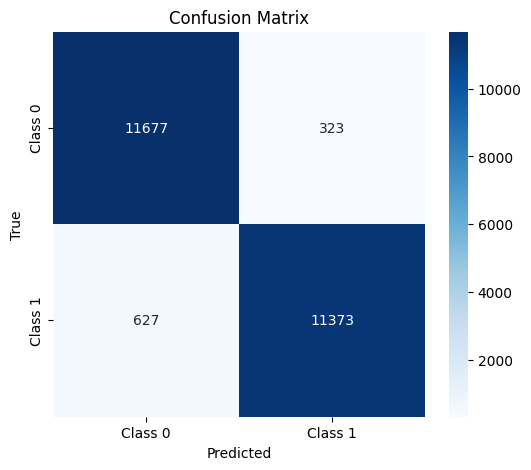

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [6]:
print("Resampled Class Distribution:")
print(y_resampled.value_counts())

Resampled Class Distribution:
binary_label
0    40000
1    40000
Name: count, dtype: int64


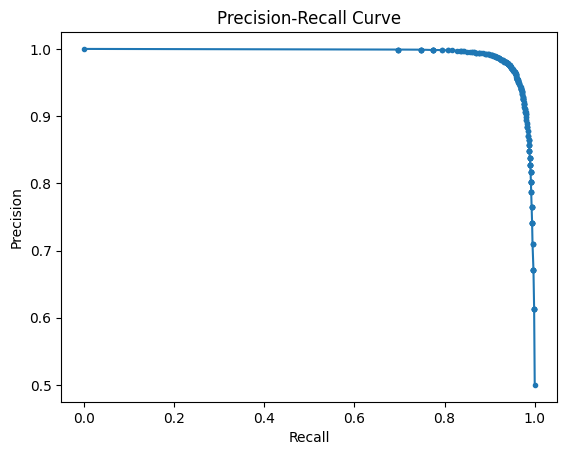

Precision-Recall AUC: 0.9924764599704863


In [7]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

y_test_proba = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# Area under the precision-recall curve
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

In [8]:
y_train_pred = rf_classifier.predict(X_train)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Evaluate on test data
y_test_pred = rf_classifier.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28000
           1       1.00      1.00      1.00     28000

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000

Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12000
           1       0.97      0.95      0.96     12000

    accuracy                           0.96     24000
   macro avg       0.96      0.96      0.96     24000
weighted avg       0.96      0.96      0.96     24000



In [4]:
# Assuming you have a DataFrame `df` with a column 'url_type'
value_counts = df['url_type'].value_counts()
print(value_counts)

url_type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


In [17]:
import pandas as pd

# URL to predict
url_to_predict = "vanderbilt.rivals.com/viewcoach.asp?coach=2079&sport=1&year=2011"

def extract_features(url):
    # Ensure the URL has a scheme (http:// or https://)
    if not url.startswith(('http://', 'https://')):
        url = 'http://' + url

    features = {}

    # Parsing URL components
    parsed_url = urllib.parse.urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path
    query = parsed_url.query
    tld = domain.split('.')[-1] if '.' in domain else ''
    
    # Helper functions
    def char_count(text, chars):
        return sum(1 for c in text if c in chars)
    
    def entropy(text):
        if len(text) == 0:
            return 0
        probabilities = [n_x / len(text) for x, n_x in Counter(text).items()]
        return -sum(p * math.log2(p) for p in probabilities if p > 0)

    def character_continuity_rate(text):
        if len(text) == 0:
            return 0
        max_continuous = 0
        current_count = 1
        for i in range(1, len(text)):
            if text[i] == text[i - 1]:
                current_count += 1
            else:
                max_continuous = max(max_continuous, current_count)
                current_count = 1
        max_continuous = max(max_continuous, current_count)
        return max_continuous / len(text)

    # Feature calculations with checks for missing values
    domain_tokens = domain.split('.') if domain else []
    path_tokens = path.split('/') if path else []
    query_tokens = query.split('&') if query else []
    
    domain_letter_count = sum(len(token) for token in domain_tokens) if domain_tokens else 0
    path_letter_count = sum(len(token) for token in path_tokens) if path_tokens else 0
    domain_digit_count = char_count(domain, '0123456789') if domain else 0

    # Handle missing or zero-length components by setting default values
    features['domain_token_count'] = len(domain_tokens) if domain_tokens else 0
    features['path_token_count'] = len(path_tokens) if path_tokens else 0
    features['avgdomaintokenlen'] = domain_letter_count / len(domain_tokens) if domain_tokens else 0
    features['longdomaintokenlen'] = max(len(token) for token in domain_tokens) if domain_tokens else 0
    features['ldl_domain'] = len(domain) if domain else 0
    features['ldl_path'] = len(path) if path else 0
    features['subDirLen'] = len('/'.join(path_tokens[:-1])) if path_tokens else 0
    features['pathurlRatio'] = len(path) / len(url) if url else 0
    features['argDomanRatio'] = len(query) / len(domain) if domain else 0
    features['domainUrlRatio'] = len(domain) / len(url) if url else 0
    features['NumberofDotsinURL'] = url.count('.') if url else 0
    features['CharacterContinuityRate'] = character_continuity_rate(url) if url else 0
    features['host_DigitCount'] = domain_digit_count
    features['host_letter_count'] = domain_letter_count
    features['Directory_LetterCount'] = path_letter_count
    features['Domain_LongestWordLength'] = max(len(token) for token in domain_tokens) if domain_tokens else 0
    features['sub-Directory_LongestWordLength'] = max(len(token) for token in path_tokens[:-1]) if len(path_tokens) > 1 else 0

    # Adding additional features (with default values for missing parts)
    features['URLQueries_variable'] = len(query_tokens) if query_tokens else 0
    features['delimeter_Domain'] = domain.count('.') if domain else 0
    features['delimeter_Count'] = url.count('/') + url.count('?') + url.count('&') if url else 0
    features['SymbolCount_URL'] = char_count(url, "!@#$%^&*()_+{}:\"<>?[];',./\\|`~") if url else 0
    
    # Print extracted features for debugging
    print(f"Extracted features for URL '{url}':")
    print(features)

    # Return the 20 features, ensuring all are filled even if some were missing
    return [features.get(key, 0) for key in selected_features]

# Extract features
features = extract_features(url_to_predict)

# Convert to DataFrame with the correct feature names
features_df = pd.DataFrame([features], columns=selected_features)

# Make prediction
predicted_probabilities = rf_classifier.predict_proba(features_df)
predicted_class = rf_classifier.predict(features_df)[0]  # Predict class (0 for benign, 1 for malicious)

# Display results
print(f"Predicted class: {'Malicious' if predicted_class == 1 else 'Benign'}")
print(f"Predicted probabilities: {predicted_probabilities}")


Extracted features for URL 'http://vanderbilt.rivals.com/viewcoach.asp?coach=2079&sport=1&year=2011':
{'domain_token_count': 3, 'path_token_count': 2, 'avgdomaintokenlen': 6.333333333333333, 'longdomaintokenlen': 10, 'ldl_domain': 21, 'ldl_path': 14, 'subDirLen': 0, 'pathurlRatio': 0.19718309859154928, 'argDomanRatio': 1.3333333333333333, 'domainUrlRatio': 0.29577464788732394, 'NumberofDotsinURL': 3, 'CharacterContinuityRate': 0.028169014084507043, 'host_DigitCount': 0, 'host_letter_count': 19, 'Directory_LetterCount': 13, 'Domain_LongestWordLength': 10, 'sub-Directory_LongestWordLength': 0, 'URLQueries_variable': 3, 'delimeter_Domain': 2, 'delimeter_Count': 6, 'SymbolCount_URL': 10}
Predicted class: Malicious
Predicted probabilities: [[0.03556364 0.96443636]]


In [21]:
# Import SHAP
import shap
import matplotlib.pyplot as plt

# Binary Classification SHAP Analysis
print("Binary Classification SHAP Analysis")

# Create SHAP explainer for the binary model
binary_explainer = shap.TreeExplainer(rf_classifier)

# Calculate SHAP values for the test set
binary_shap_values = binary_explainer.shap_values(X_test)

# Force plot for a single instance
shap.force_plot(
    binary_explainer.expected_value[1],  # Base value for class 1 (malicious)
    binary_shap_values[1][0],           # SHAP values for the first test instance
    X_test.iloc[0],                     # Feature values for the first test instance
    matplotlib=True                     # Use Matplotlib for visualization
)

# Summary plot for the binary model
shap.summary_plot(binary_shap_values[1], X_test, plot_type="bar")
shap.summary_plot(binary_shap_values[1], X_test)

# Multiclass Classification SHAP Analysis
print("Multiclass Classification SHAP Analysis")

# Create SHAP explainer for the multiclass model
multiclass_explainer = shap.TreeExplainer(rf_multiclass_classifier)

# Calculate SHAP values for the test set
multiclass_shap_values = multiclass_explainer.shap_values(X_test_multi)

# Force plot for a single instance and class
selected_class = 1  # Change this to analyze other classes
shap.force_plot(
    multiclass_explainer.expected_value[selected_class],  # Base value for the selected class
    multiclass_shap_values[selected_class][0],            # SHAP values for the first test instance
    X_test_multi.iloc[0],                                 # Feature values for the first test instance
    matplotlib=True                                       # Use Matplotlib for visualization
)

# Summary plot for the multiclass model
shap.summary_plot(multiclass_shap_values, X_test_multi, plot_type="bar")
shap.summary_plot(multiclass_shap_values, X_test_multi)


Binary Classification SHAP Analysis


DimensionError: Length of features is not equal to the length of shap_values!